In [2]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
import scipy.stats
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_26030/354749697.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [3]:
"""Settings."""
d = 100 # dimension
k = 4 # sparsity
n = 2000 # sample size
K = 300 # number of subgroups
p = 0.05 # corruption probability
mu = np.zeros(d)
mu_sparse = [5, -2, -1.5, 2]
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))
trial_num = 10
eta = 0.07
rho = 1
max_iter = 2000
variance = 3.3

In [5]:
"""GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    # X = np.random.normal(0, 1, size=(n, d))
    X = np.empty((n, d))
    # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    for i in range(n):
        for j in range(d):
            X[i][j] = variance * np.random.lognormal() * (2 * np.random.randint(0,2) - 1)

    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        X[j, :] = 20 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50

    idx = np.arange(n)
    np.random.shuffle(idx)

    idx_split = np.array_split(idx, K)
    X_grouped = []
    for i in range(K):
        idx_tmp = idx_split[i]
        X_tmp = [X[j] for j in idx_tmp]
        X_grouped.append(list(np.mean(X_tmp, axis = 0)))
    
    # X_split = np.array_split(S, K)
    # X_grouped = []
    # for i in X_split:
    #     X_grouped.append(list(np.mean(i, axis = 0)))
    #X_grouped = np.mean(X_grouped, axis=1)
    X_grouped = np.array(X_grouped)

    print(X_grouped)

    # Grouping preprocessing
    # X_grouped = np.split(X, K)
    # X_grouped = np.mean(X_grouped, axis=1)

    # initialize the parameters
    alpha = 1e-10
    u = alpha * np.ones((d, 1))
    v = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
            grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
        u -= eta * grad_u / K
        v -= eta * grad_v / K
        eta *= rho
        dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
        error[t] = abs(u * u - v * v - mu)
        pred[t] = abs(u * u - v * v)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

[[ 0.83622271 -3.71068085  0.25748696 ...  0.25292966  3.14046368
   0.01581132]
 [ 2.973718   -3.53430096 -4.90200911 ... -2.65453963  3.8451543
  -0.06857368]
 [ 6.92894113 -2.99268902 -2.18778347 ... -3.60965236  0.12604925
  -1.60776826]
 ...
 [ 4.53227981 -2.5190697  -2.22773636 ...  0.92356808  1.3535318
   4.42559428]
 [ 6.88005251 -5.18843132  2.94662712 ... -2.36046881  2.30831561
  -5.40272938]
 [ 4.35917524 -5.39757171  0.5835614  ...  2.70886128  8.0363078
  -0.13198283]]
[[ 2.29622323e+01  6.27073577e+00  1.30051438e+01 ...  1.59930309e+01
   6.86066352e+00  2.88242958e+01]
 [ 1.05044343e+01 -4.58012237e+00 -2.68737801e-02 ...  3.88759835e+00
   5.29351834e+00  9.46435262e-01]
 [ 5.59364474e+00 -4.62583550e-01 -6.20110371e-01 ... -1.84315203e+01
   1.53264640e+00 -2.79416340e+00]
 ...
 [ 2.15133186e+01 -8.09338712e+00 -3.52781129e+01 ...  5.03829171e+00
  -5.23092463e+01  5.26786946e+00]
 [ 6.80629915e+00  1.62392393e-01  1.24694849e+00 ... -7.81298512e-01
  -2.44386003e+0

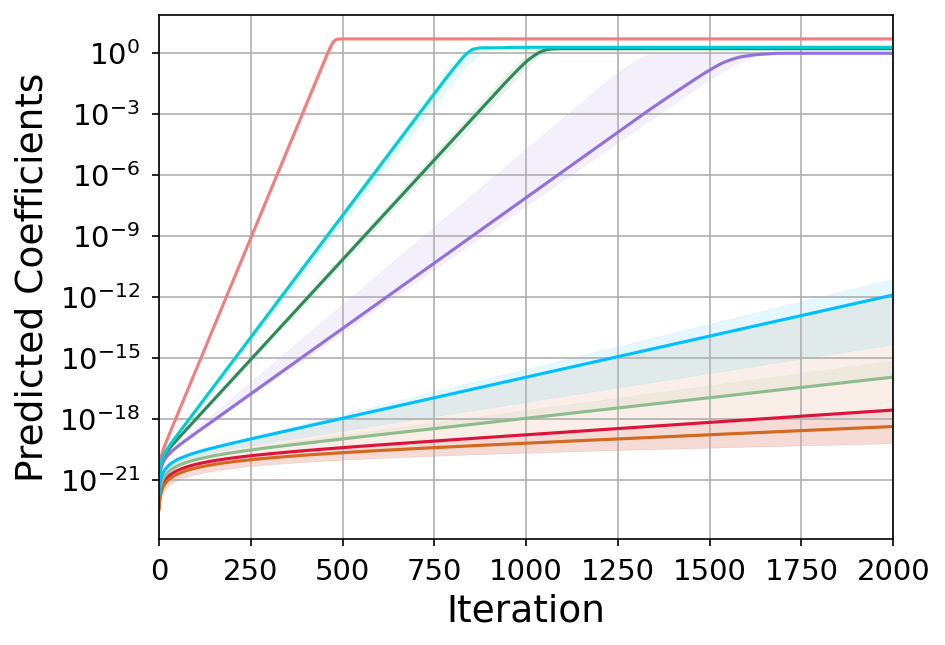

In [6]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[1]
        med[i][t] = sorted[2]
        maxs[i][t] = sorted[3]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.1)
    plt.plot(med[i], color=col[i], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, max_iter)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

plt.savefig(f"../figs/nonconvex-epsilon={p}-variance={variance}-mu={mu_sparse}.pdf")
plt.show()

In [4]:
"""Single-variable GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    # X = np.random.normal(0, 1, size=(n, d))
    X = np.empty((n, d))
    # # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    for i in range(n):
        for j in range(d):
            X[i][j] = variance * np.random.lognormal() * (2 * np.random.randint(0,2) - 1)
    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        X[j, :] = 40 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50

    idx = np.arange(n)
    np.random.shuffle(idx)

    idx_split = np.array_split(idx, K)
    X_grouped = []
    for i in range(K):
        idx_tmp = idx_split[i]
        X_tmp = [X[j] for j in idx_tmp]
        X_grouped.append(list(np.mean(X_tmp, axis = 0)))
    
    # X_split = np.array_split(S, K)
    # X_grouped = []
    # for i in X_split:
    #     X_grouped.append(list(np.mean(i, axis = 0)))
    #X_grouped = np.mean(X_grouped, axis=1)
    X_grouped = np.array(X_grouped)

    print(X_grouped)

    # initialize the parameters
    alpha = 1e-10
    u = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u)
        u -= eta * grad_u / K
        eta *= rho
        dists[t] = np.linalg.norm(u - mu, ord=1)
        error[t] = abs(u - mu)
        pred[t] = abs(u)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

[[  9.24246752   2.13911271  -0.13389837 ... -22.53376012 -14.37669542
    0.76274341]
 [  6.09713997  -4.84997786   1.53318432 ...   0.69908514   2.86496778
   -3.04850461]
 [  4.65327467  -1.9461659  -11.30123287 ...   1.81991747   0.93686124
   -3.7757489 ]
 ...
 [  4.80654159  -7.12434778  -0.92916792 ...  -0.33321776   0.35710111
    5.88028402]
 [  3.25529947  -7.70167259  -1.06378278 ...  -0.21316873   0.44278216
    1.19409316]
 [ -8.40132254   2.52104062  10.78645583 ...   2.55934543  -2.39943845
   61.20968647]]
[[  7.97634816  -1.81803682  -3.56468427 ...   1.28219418   0.60737936
    2.79086519]
 [ 13.80401768   3.91454785  -1.53498434 ...  36.02562509  18.45194727
    5.79697085]
 [-11.21893754  42.75869281 -22.91883944 ...  87.55202302  70.22656642
   26.83919   ]
 ...
 [  3.73130266  -4.39777788  -1.10250319 ...   1.77252828  -2.51524954
    0.30287082]
 [  6.88319635   1.18681843   0.20228436 ...  -3.21190128  -1.40647825
    8.2583199 ]
 [-21.90827851  21.91198231  11.

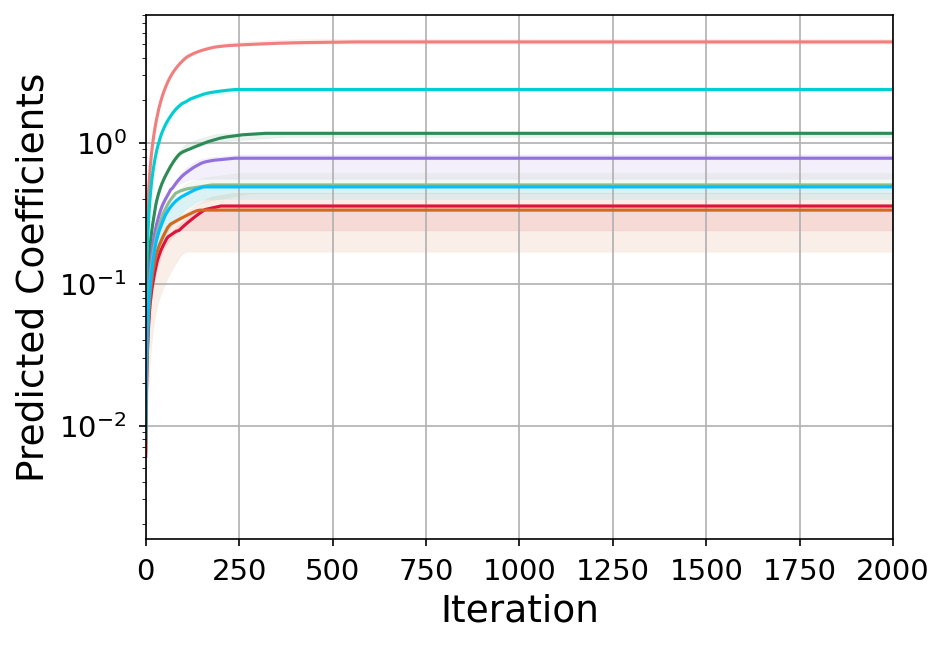

In [5]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[1]
        med[i][t] = sorted[2]
        maxs[i][t] = sorted[3]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.1)
    plt.plot(med[i], color=col[i], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, max_iter)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

plt.savefig(f"../figs/convex-epsilon={p}-variance={variance}-mu={mu_sparse}.pdf")
plt.show()

In [13]:
"""Settings."""
d = 100 # dimension
k = 4 # sparsity
n = 800 # sample size
p = 0.05 # corruption probability
K = int(2*p*n) # number of subgroups
mu = np.zeros(d)
mu_sparse = 2 * np.ones(k)
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))
trial_num = 10
eta = 0.05
rho = 1
max_iter = 1000
variance = 1

In [14]:
"""GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    # X = np.random.normal(0, 1, size=(n, d))
    X = np.empty((n, d))
    # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    
    for i in range(n):
        for j in range(d):
            #X[i][j] = variance * np.random.lognormal() * (2 * np.random.randint(0,2) - 1)
            X[i][j] = 4 * variance * scipy.stats.pareto.rvs(2.74) * (2 * np.random.randint(0,2) - 1)
    
    #X = variance * scipy.stats.t.rvs(2.74,size = (n,d))
    #X = variance * np.random.randn(n,d)

    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        #X[j, :] = 40 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50
        X[j, :] += -2

    idx = np.arange(n)
    np.random.shuffle(idx)

    idx_split = np.array_split(idx, K)
    X_grouped = []
    for i in range(K):
        idx_tmp = idx_split[i]
        X_tmp = [X[j] for j in idx_tmp]
        X_grouped.append(list(np.mean(X_tmp, axis = 0)))
    
    # X_split = np.array_split(S, K)
    # X_grouped = []
    # for i in X_split:
    #     X_grouped.append(list(np.mean(i, axis = 0)))
    #X_grouped = np.mean(X_grouped, axis=1)
    #print(X_grouped)
    X_grouped = np.array(X_grouped)

    # Grouping preprocessing
    # X_grouped = np.split(X, K)
    # X_grouped = np.mean(X_grouped, axis=1)
    
    # initialize the parameters
    alpha = 1e-5
    u = alpha * np.ones((d, 1))
    v = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
            grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
        u -= eta * grad_u / K
        v -= eta * grad_v / K
        eta *= rho
        dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
        error[t] = abs(u * u - v * v - mu)
        pred[t] = abs(u * u - v * v)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

(10, 1000, 100, 1)
(100, 1000, 10, 1)


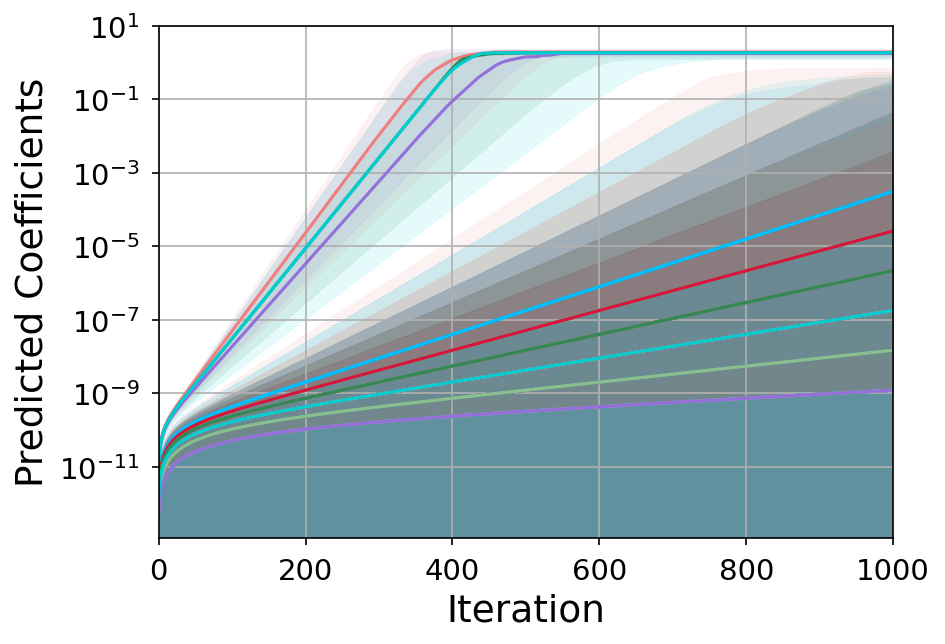

In [20]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(d):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[0]
        med[i][t] = sorted[trial // 2]
        maxs[i][t] = sorted[-2]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i%8], alpha=0.1)
    plt.plot(med[i], color=col[i%8], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, max_iter)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

#plt.savefig(f'figs/convex-epsilon={p}-variance={variance}-mu={mu_sparse}.pdf')
plt.show()